### Workbook for exploring catchment survey data and replicating methods from 2021 paper
Week of June 9, 2025
<br>
Author: Adele Birkenes

Objectives of 2021 study (pg. 5):
- Understand the geographic area served by a completed bridge and validate the current needs assessment approach by comparing the geographic area served to the estimate of individuals directly served determined as part of the needs assessment
- Understand the specific ways in which completed trailbridges serve as connections to key destinations

The GIS methods in the paper are as follows:
<br>
5.1 Calculate summary statistics on number of individuals surveyed, demographics (age range and gender), and modes of transportation

5.2 Calculate total catchment area of each site in sq km, and count number of unique villages served by the site. Compare number of unique villages to "qualified home villages" from the needs assessment.
- Calculate the proportion of respondents reporting a given home village or destination
- Calculate mean Euclidean distance from bridge to centroid of farthest home village with one or more surveys
- Determine which of the home villages from the catchment surveys are considered "qualified" based on whether they meet the criteria for individuals directly served, based on reported purpose of travel

Sample outputs:

| Bridge Site | Catchment area, all home and destination villages | Catchment area (sq km) | Catchment area, qualified home villages | Qualified home villages (needs assessment) |
|-------------|---------------------------------------------------|------------------------|------------------------------------------|---------------------------------------------|
| Gahororo    | 27                                                | 44.6                   | 18                                       | 4                                           |

<br>
<img src="graphics/Figure4.png" alt="Figure 4" width="400"/>
<br>
<img src="graphics/Figure5.png" alt="Figure 5" width="400"/>

5.3 Calculate summary statistics on purpose of travel, disaggregated by gender

5.4 Calculate travel time for a one-way trip between home village and destination, disaggregated by purpose of travel and gender
- Exclude multi-day trips

In [39]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString, Polygon
import os
import matplotlib.pyplot as plt

Task 1: Read in Rwanda bridge sites (df), catchment survey data (df), and village boundaries (gdf)

In [40]:
synced_catchment_path = "../../synced-data/catchment-analysis"
synced_population_path = "../../synced-data/population-exploration"

# Rwanda bridge sites
Rwanda_bridges_fp = os.path.join(synced_catchment_path, "Rwanda_catchment_bridge_sites.csv")
Rwanda_bridges = pd.read_csv(Rwanda_bridges_fp, encoding='ISO-8859-1') # Note: This encoding accommodates special characters)

# Rwanda catchment survey data
Rwanda_catchment_surveys_fp = os.path.join(synced_catchment_path, "Rwanda_catchment_all_surveys.csv")
Rwanda_catchment_surveys = pd.read_csv(Rwanda_catchment_surveys_fp, encoding='ISO-8859-1')

# Rwanda village boundaries
Rwanda_village_boundaries_fp = os.path.join(synced_population_path, "Rwanda Village Boundaries/Village.shp")
Rwanda_village_boundaries = gpd.read_file(Rwanda_village_boundaries_fp, encoding='ISO-8859-1')

Task 2: Convert bridge sites dataframe to geodataframe that has custom Rwanda TM CRS copied from village boundaries geodataframe

In [41]:
# Convert bridge sites dataframe to geodataframe that has custom Rwanda TM CRS copied from village boundaries geodataframe
def map_bridges(bridges, bridges_lat, bridges_lon, village_boundaries):

    # Check CRS of village boundaries gdf
    print(f'The CRS of the village boundaries gdf is: {village_boundaries.crs}')

    # Create lat/lon variables
    lon = bridges[bridges_lon]
    lat = bridges[bridges_lat]

    # Create gdf of bridges data by converting lat/lon values to list of Shapely Point objects
    bridge_points = gpd.GeoDataFrame(bridges, geometry=gpd.points_from_xy(x=lon, y=lat), crs='EPSG:4326')

    # Set CRS of bridges gdf to CRS of village boundaries gdf
    bridge_points.to_crs(village_boundaries.crs, inplace=True)

    # Check that reprojection was successful
    print(f'The CRS of the bridges gdf is: {bridge_points.crs}')
    
    return bridge_points

bridge_points = map_bridges(bridges = Rwanda_bridges,
                            bridges_lat = "Lat",
                            bridges_lon = "Long",
                            village_boundaries = Rwanda_village_boundaries)

The CRS of the village boundaries gdf is: PROJCS["TM_Rwanda",GEOGCS["ITRF2005",DATUM["International_Terrestrial_Reference_Frame_2005",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6896"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",30],PARAMETER["scale_factor",0.9999],PARAMETER["false_easting",500000],PARAMETER["false_northing",5000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
The CRS of the bridges gdf is: PROJCS["TM_Rwanda",GEOGCS["ITRF2005",DATUM["International_Terrestrial_Reference_Frame_2005",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6896"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",30],PARAMETER["scale_factor",0.9999],PARAMETER["false_

Task 3: For each bridge site, calculate the number of catchment villages (home or destination). Calculate the proportion of respondents reporting a given home/destination village.

In [42]:
# For each bridge site, count the number of unique home and destination admin codes
def count_catchment_villages_by_site(catchment_surveys):
    # Group by 'Bridge Site' and count unique home and destination admin codes
    result = catchment_surveys.groupby('Bridge Site').apply(
        lambda group: pd.Series({
            'unique_home_and_destination_admin_codes': pd.concat([
                group['Home Village - Admin Code'].dropna(),
                group['Destination - Admin Code'].dropna()
            ]).nunique()
        })
    ).reset_index()
    
    return result

# Apply the function
catchment_village_counts = count_catchment_villages_by_site(Rwanda_catchment_surveys)
print(catchment_village_counts)

         Bridge Site  unique_home_and_destination_admin_codes
0           Gahororo                                       32
1             Gasasa                                       56
2          Kanyarira                                       72
3            Muhembe                                       55
4           Muregeya                                       55
5        Mutiwingoma                                       66
6         Nyarusange                                       91
7            Rugeshi                                       71
8           Ruharazi                                       18
9          Rwamamara                                       42
10          Rwimvubu                                       57
11  Uwumugeti-Kigusa                                       43


/var/folders/k3/5zvypv9111d6n3b8k2wb1bc00000gn/T/ipykernel_78158/2757783136.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = catchment_surveys.groupby('Bridge Site').apply(


In [43]:
# Create a dataframe that counts the number of respondents who reported each home village for each bridge site
def count_respondents_by_home_village(catchment_surveys):
    # Group by 'Bridge Site' and 'Home Village - Admin Code', then count unique respondents
    result = catchment_surveys.groupby(['Bridge Site', 'Home Village - Admin Code']).size().reset_index(name='respondent_count')
    
    # Create a column for proportion of respondents reporting a given village for each bridge site
    total_respondents = catchment_surveys.groupby('Bridge Site').size().reset_index(name='total_respondents')
    result = result.merge(total_respondents, on='Bridge Site')
    result['proportion'] = result['respondent_count'] / result['total_respondents']
    result = result.drop(columns='total_respondents')
    result = result.sort_values(by=['Bridge Site', 'proportion'], ascending=[True, False])
    
    return result

# Apply the function
respondent_counts_home_village = count_respondents_by_home_village(Rwanda_catchment_surveys)
print(respondent_counts_home_village)

          Bridge Site Home Village - Admin Code  respondent_count  proportion
16           Gahororo                  24030501               205    0.207700
20           Gahororo                  24030505               131    0.132725
17           Gahororo                  24030502                99    0.100304
14           Gahororo                  24030306                90    0.091185
11           Gahororo                  24030203                89    0.090172
..                ...                       ...               ...         ...
345  Uwumugeti-Kigusa                      2313                 1    0.001992
346  Uwumugeti-Kigusa                  23130401                 1    0.001992
347  Uwumugeti-Kigusa                  25010202                 1    0.001992
350  Uwumugeti-Kigusa                  25080304                 1    0.001992
354  Uwumugeti-Kigusa                    251601                 1    0.001992

[364 rows x 4 columns]


In [44]:
# Create a dataframe that counts the number of respondents who reported each destination village for each bridge site
def count_respondents_by_destination_village(catchment_surveys):
    # Group by 'Bridge Site' and 'Destination Village - Admin Code', then count unique respondents
    result = catchment_surveys.groupby(['Bridge Site', 'Destination - Admin Code']).size().reset_index(name='respondent_count')
    
    # Create a column for proportion of respondents reporting a given village for each bridge site
    total_respondents = catchment_surveys.groupby('Bridge Site').size().reset_index(name='total_respondents')
    result = result.merge(total_respondents, on='Bridge Site')
    result['proportion'] = result['respondent_count'] / result['total_respondents']
    result = result.drop(columns='total_respondents')
    result = result.sort_values(by=['Bridge Site', 'proportion'], ascending=[True, False])
    
    return result

# Apply the function
respondent_counts_destination_village = count_respondents_by_destination_village(Rwanda_catchment_surveys)
print(respondent_counts_destination_village)

          Bridge Site  Destination - Admin Code  respondent_count  proportion
2            Gahororo                24030306.0               874    0.885512
4            Gahororo                24030501.0                49    0.049645
6            Gahororo                24030505.0                45    0.045593
3            Gahororo                24030307.0                 8    0.008105
0            Gahororo                24010202.0                 6    0.006079
..                ...                       ...               ...         ...
280  Uwumugeti-Kigusa                25040305.0                 1    0.001992
281  Uwumugeti-Kigusa                25060601.0                 1    0.001992
282  Uwumugeti-Kigusa                25080304.0                 1    0.001992
289  Uwumugeti-Kigusa                25160503.0                 1    0.001992
291  Uwumugeti-Kigusa                25160506.0                 1    0.001992

[294 rows x 4 columns]


Task 4: For each bridge site, join the catchment survey data to the village boundaries using admin code

In [45]:
# For each bridge site, create two dataframes: one for home villages and one for destination villages
# Pull from above dataframes summarizing respondent counts and proportions
def create_bridge_village_dfs(respondent_counts_home_village, respondent_counts_destination_village):
    output_dfs = {}
    
    for bridge in respondent_counts_home_village['Bridge Site'].unique():
        selected_columns = ['Bridge Site', 'Home Village - Admin Code', 'respondent_count', 'proportion']
        home_village_df = respondent_counts_home_village[respondent_counts_home_village['Bridge Site'] == bridge][selected_columns]
        output_dfs[f"{bridge}_home_village_df"] = home_village_df
    
    for bridge in respondent_counts_destination_village['Bridge Site'].unique():
        selected_columns = ['Bridge Site', 'Destination - Admin Code', 'respondent_count', 'proportion']
        destination_village_df = respondent_counts_destination_village[respondent_counts_destination_village['Bridge Site'] == bridge][selected_columns]
        output_dfs[f"{bridge}_destination_village_df"] = destination_village_df
    
    return output_dfs

# Apply the function to create the bridge village dataframes
bridge_village_dfs = create_bridge_village_dfs(respondent_counts_home_village, respondent_counts_destination_village)

# Print the keys of the output dictionary to verify
print("Created bridge catchment village dataframes:")
for key in bridge_village_dfs.keys():
    print(key)

# Print the first few rows of each dataframe to verify
for key, df in bridge_village_dfs.items():
    print(f"\n{key}:\n", df.head())

Created bridge catchment village dataframes:
Gahororo_home_village_df
Gasasa_home_village_df
Kanyarira_home_village_df
Muhembe_home_village_df
Muregeya_home_village_df
Mutiwingoma_home_village_df
Nyarusange_home_village_df
Rugeshi_home_village_df
Ruharazi_home_village_df
Rwamamara_home_village_df
Rwimvubu_home_village_df
Uwumugeti-Kigusa_home_village_df
Gahororo_destination_village_df
Gasasa_destination_village_df
Kanyarira_destination_village_df
Muhembe_destination_village_df
Muregeya_destination_village_df
Mutiwingoma_destination_village_df
Nyarusange_destination_village_df
Rugeshi_destination_village_df
Ruharazi_destination_village_df
Rwamamara_destination_village_df
Rwimvubu_destination_village_df
Uwumugeti-Kigusa_destination_village_df

Gahororo_home_village_df:
    Bridge Site Home Village - Admin Code  respondent_count  proportion
16    Gahororo                  24030501               205    0.207700
20    Gahororo                  24030505               131    0.132725
17    Ga

In [58]:
# Data cleaning: Remove decimal points from admin codes for destination villages
def clean_destination_village_codes(destination_village_df):
    destination_village_df['Destination - Admin Code'] = destination_village_df['Destination - Admin Code'].astype(str).str.replace('.', '', regex=False)
    return destination_village_df

# Apply the cleaning function to each destination village dataframe in the dictionary
for key in bridge_village_dfs.keys():
    if 'destination' in key:
        bridge_village_dfs[key] = clean_destination_village_codes(bridge_village_dfs[key])

# Print the cleaned dataframes to verify
for key, df in bridge_village_dfs.items():
    if 'destination' in key:
        print(f"\nCleaned {key}:\n", df.head())


Cleaned Gahororo_destination_village_df:
   Bridge Site Destination - Admin Code  respondent_count  proportion
2    Gahororo                240303060               874    0.885512
4    Gahororo                240305010                49    0.049645
6    Gahororo                240305050                45    0.045593
3    Gahororo                240303070                 8    0.008105
0    Gahororo                240102020                 6    0.006079

Cleaned Gasasa_destination_village_df:
    Bridge Site Destination - Admin Code  respondent_count  proportion
27      Gasasa                350501050               243    0.408403
18      Gasasa                350103010               215    0.361345
22      Gasasa                350104030                20    0.033613
20      Gasasa                350103030                19    0.031933
19      Gasasa                350103020                18    0.030252

Cleaned Kanyarira_destination_village_df:
    Bridge Site Destination - Admin Cod

In [57]:
# For each bridge catchment village dataframe, join it with the village boundaries geodataframe
def join_village_gdfs_with_boundaries(bridge_village_dfs, village_boundaries):
    joined_gdfs = {}
    
    for key, df in bridge_village_dfs.items():
        # Determine whether it's a home or destination village dataframe
        if 'home' in key:
            join_column = 'Home Village - Admin Code'
        else:
            join_column = 'Destination - Admin Code'
        
        # Ensure both columns are of the same type before merging
        village_boundaries['Village_ID'] = village_boundaries['Village_ID'].astype(str)
        df[join_column] = df[join_column].astype(str)
        
        # Join with village boundaries geodataframe
        joined_gdf = village_boundaries.merge(df, left_on='Village_ID', right_on=join_column, how='inner')
        
        # Rename the key to replace 'df' with 'gdf'
        new_key = key.replace('_df', '_gdf')
        joined_gdfs[new_key] = joined_gdf
    
    return joined_gdfs

# Apply the function to join the village dataframes with the village boundaries geodataframe
joined_bridge_village_gdfs = join_village_gdfs_with_boundaries(bridge_village_dfs, Rwanda_village_boundaries)

# Print the keys of the output dictionary to verify
print("Joined bridge catchment village geodataframes:")
for key in joined_bridge_village_gdfs.keys():
    print(key)

# Print the first few rows of each joined geodataframe to verify
for key, gdf in joined_bridge_village_gdfs.items():
    print(f"\n{key} - First few rows:")
    print(gdf.head())

Joined bridge catchment village geodataframes:
Gahororo_home_village_gdf
Gasasa_home_village_gdf
Kanyarira_home_village_gdf
Muhembe_home_village_gdf
Muregeya_home_village_gdf
Mutiwingoma_home_village_gdf
Nyarusange_home_village_gdf
Rugeshi_home_village_gdf
Ruharazi_home_village_gdf
Rwamamara_home_village_gdf
Rwimvubu_home_village_gdf
Uwumugeti-Kigusa_home_village_gdf
Gahororo_destination_village_gdf
Gasasa_destination_village_gdf
Kanyarira_destination_village_gdf
Muhembe_destination_village_gdf
Muregeya_destination_village_gdf
Mutiwingoma_destination_village_gdf
Nyarusange_destination_village_gdf
Rugeshi_destination_village_gdf
Ruharazi_destination_village_gdf
Rwamamara_destination_village_gdf
Rwimvubu_destination_village_gdf
Uwumugeti-Kigusa_destination_village_gdf

Gahororo_home_village_gdf - First few rows:
    District Village_ID Cell_ID Sector_ID Distr_ID Prov_ID       Name  \
0  Nyaruguru   23140302  231403      2314       23       2       Kibu   
1  Nyaruguru   23140303  231403 

Task 5: For each bridge site, create a map of the catchment area, showing the bridge site, home villages, and destination villages

/var/folders/k3/5zvypv9111d6n3b8k2wb1bc00000gn/T/ipykernel_78158/3168109804.py:27: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  destination_gdf.plot(ax=ax, color='green', alpha=0.5, label='Destination Villages')
/var/folders/k3/5zvypv9111d6n3b8k2wb1bc00000gn/T/ipykernel_78158/3168109804.py:32: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


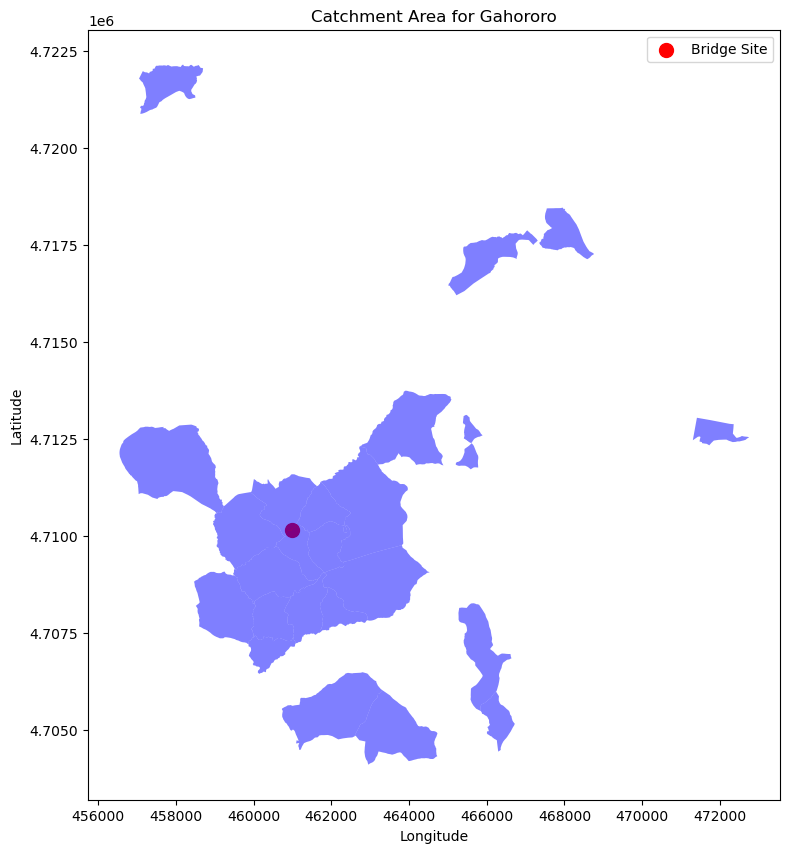

In [28]:
# Plot both home and destination villages for a given bridge site
def plot_home_and_destination_villages(bridge_site, joined_bridge_village_gdfs, bridge_points):
    # Extract the home and destination GeoDataFrames for the given bridge site
    home_gdf_key = f"{bridge_site}_home_village_gdf"
    destination_gdf_key = f"{bridge_site}_destination_village_gdf"
    
    home_gdf = joined_bridge_village_gdfs.get(home_gdf_key, None)
    destination_gdf = joined_bridge_village_gdfs.get(destination_gdf_key, None)
    
    if home_gdf is None or destination_gdf is None:
        print(f"GeoDataFrames for {bridge_site} not found.")
        return
    
    # Filter the bridge_points GeoDataFrame for the current bridge site
    bridge_point = bridge_points[bridge_points['Bridge Name'] == bridge_site]
    
    # Create a plot
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Plot the bridge site
    bridge_point.plot(ax=ax, color='red', markersize=100, label='Bridge Site')
    
    # Plot the home villages
    home_gdf.plot(ax=ax, color='blue', alpha=0.5, label='Home Villages')
    
    # Plot the destination villages
    destination_gdf.plot(ax=ax, color='green', alpha=0.5, label='Destination Villages')
    
    ax.set_title(f'Catchment Area for {bridge_site}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.legend()
    
    plt.show()

# Example usage
plot_home_and_destination_villages('Gahororo', joined_bridge_village_gdfs, bridge_points)